# Construct IVs for Pooled Sample

The newly enlarged sample

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [2]:
# helper functions

def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


## Convert between calendar date and continuous weeks

In [3]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [4]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])
    
    
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Get sample

In [5]:
# read sample data files
iv_df = pd.read_csv("../data/analytic_df.csv")
print iv_df.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'y_age35', u'y_deceased', u'last_yr', u'attr_before35',
       u'deceased_before35', u'y_child18', u'deceased_child18',
       u'attr_child18'],
      dtype='object')


In [6]:
iv_df = iv_df[['caseid_1979', 'c1dob_y_xrnd', 'c1dob_m_xrnd', 'y_dob', 'm_dob']]
iv_df = iv_df.rename(index=str, columns={"c1dob_y_xrnd": "childbirth_year", "c1dob_m_xrnd":"childbirth_month"})
sample = iv_df.caseid_1979.values.tolist()
print len(sample)

3434


## Age at first birth 

Use respondent's birth year reported in 1979

In [7]:
def get_age(row):
    """Use both year and month to determine age"""

    birth_month = datetime(int(row["childbirth_year"]), int(row["childbirth_month"]), 1)
    prebirth_month = birth_month - timedelta(days=1) 
    return prebirth_month.year - row["y_dob"] - (prebirth_month.month < row['m_dob'])

iv_df["age"] = iv_df.apply(get_age, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age
0,2,1993,3,1959,1,34
1,3,1981,6,1961,8,19
2,4,1980,8,1962,8,17
3,8,1976,3,1958,7,17
4,16,1990,2,1958,10,31


## Education

Get highest degree/education from last survey report prior to birth

* Type 1: no last survey report prior to birth (733 cases)

At the time of pulling, i.e. one month prior to birth, if less than age 18 (strictly), assign no hs. Otherwise, use education reported in 1979. 


* Type 2: mother gave birth after >= 1979 survey, use last survey report prior to birth. **It is possible that the last survey report is from the same year as prebirth month, as long as interview month is before birth month**

Use highest grade completed (revised) --- These variables represent the highest grade completed by the respondent as of May 1 survey year. These are created with some adjustments to keep people from regressing in years of schooling when they take such actions as returning to school in a new field.

In [8]:
hi_grade_df = pd.read_csv('../data/hi_grade_new.csv')
hi_grade_df.head()

,caseid_1979,q3_4_1979,hgc_1979,hgcrev79_1979,q3_4_1980,hgc_1980,hgcrev80_1980,q3_4_1981,hgc_1981,hgcrev81_1981,...,q3_4_2008,hgc_2008,hgcrev08_2008,q3_4_2010,hgc_2010,hgcrev10_2010,q3_4_2012,hgc_2012,q3_4_2014,hgc_2014
0,1,12,12,12,-5,-5,-5,-4,12,12,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,9,9,9,-4,9,9,-4,9,9,...,13,12,12,13,12,12,13,12,12,12
2,3,10,10,10,10,10,10,-5,-5,-5,...,12,12,12,-5,-5,-5,10,12,10,12
3,4,9,9,9,-5,-5,-5,-4,9,9,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,13,13,13,14,14,14,15,15,15,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [9]:
# read interview dates
intdate_df = pd.read_csv("../data/int_date.csv") 
intdate_df.head()

,caseid_1979,date_m_1979,date_d_1979,date_m_1980,date_d_1980,date_m_1981,date_d_1981,date_m_1982,date_d_1982,date_m_1983,...,date_y_2008,date_d_2010,date_m_2010,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014
0,1,3,3,-5,-5,6,25,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,2,28,3,3,2,23,2,6,2,...,2008,10,3,2010,3,12,2012,26,12,2014
2,3,2,8,5,20,-5,-5,3,11,3,...,2008,-5,-5,-5,19,3,2013,8,5,2015
3,4,2,8,-5,-5,3,24,3,3,1,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,4,19,4,3,3,12,3,1,4,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5


In [10]:
# check different scenarios
# merge data to access variables easily 
merged = iv_df.merge(hi_grade_df, on='caseid_1979')
merged = merged.merge(intdate_df, on='caseid_1979')

In [11]:
# no missing interview date in 1979 - OF COURSE
merged.date_m_1979.value_counts(dropna=False)

3    1442
2     980
4     663
5     264
7      50
6      24
1       6
8       5
Name: date_m_1979, dtype: int64

In [12]:
def has_no_survey_prebirth(row):
    """
    Return True if R was not interviewered prior to birth
    """
    
    return datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1) <= datetime(1979, int(row['date_m_1979']), 1)


merged['no_report'] = merged.apply(has_no_survey_prebirth, axis=1)
merged.no_report.value_counts()

False    2701
True      733
Name: no_report, dtype: int64

In [13]:
def get_hi_grade(row):
    """
    Given a row of a respondent's data, return the degree **from last survey report prior to birth**
    
    If no survey report prior to birth:
        # At the time of pulling, i.e. one month prior to birth, if less than age 18 (strictly), assign no hs
        # Otherwise, use education in 1979
        
    If mother gave birth after >= 1979 survey:
        return the degree from last survey report prior to birth
        
    """
    
    birth_month = datetime(int(row["childbirth_year"]), int(row["childbirth_month"]), 1)
    
    if row['no_report']:
        
        # this gives us the last day of prebirth month
        # we will only use the year and month, the day doesn't matter
        prebirth_month = birth_month - timedelta(days=1) 
        prebirth_age = prebirth_month.year - row["y_dob"] - (prebirth_month.month < row['m_dob'])
        
        if prebirth_age < 18:
            return -1 # assume less than high school
        else:
            if row['hgcrev79_1979'] >= 0: # valid grade
                return row['hgcrev79_1979']
            else:
                print 'missing grade:', int(row['caseid_1979'])
                return None
            
    else:
        
        # up to 2010, REVISED highest grade is not provided in 2012 or 2014
        years = range(1979, 1995) + range(1996, 2011, 2)

        # do not include grade 95 (which stands for ungraded study)
        # only count until the survey report prior to birth 
        vals = [row['hgcrev%s_%s'%(str(y)[2:], y)] for y in years 
            if row['hgcrev%s_%s'%(str(y)[2:], y)]<95 and \
                row['hgcrev%s_%s'%(str(y)[2:], y)]>=0 and \
                datetime(int(y), int(row['date_m_%s'%y]), 1)<birth_month]

        #return the most recent valid degree reported prior to birth 
        if len(vals) > 0:
            if vals[-1] != max(vals):
                print 'last survey report diff from highest deg:', int(row['caseid_1979']), vals[-1], max(vals)
            return vals[-1]
        
        else:
            print 'missing grade:', int(row['caseid_1979'])
            return None

        
def recode_educ(g):
    """
    Convert highest grade completed to educational category
    """
    
    if g<12: # less than high school
        return 1
        
    elif g==12: # high school
        return 2
        
    elif (g>12 and g<16): # some college
        return 3
        
    elif g==16: # college graduate
        return 4
        
    elif g>16: # advanced degree
        return 5        
        

merged["hi_deg"] = merged.apply(get_hi_grade, axis=1)
merged["educ"] = merged.hi_deg.map(recode_educ)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,q3_4_1979,hgc_1979,hgcrev79_1979,q3_4_1980,...,date_y_2010,date_d_2012,date_m_2012,date_y_2012,date_d_2014,date_m_2014,date_y_2014,no_report,hi_deg,educ
0,2,1993,3,1959,1,34,9,9,9,-4,...,2010,3,12,2012,26,12,2014,False,12,2
1,3,1981,6,1961,8,19,10,10,10,10,...,-5,19,3,2013,8,5,2015,False,10,1
2,4,1980,8,1962,8,17,9,9,9,-5,...,-5,-5,-5,-5,-5,-5,-5,False,9,1
3,8,1976,3,1958,7,17,12,12,12,-4,...,2009,8,10,2012,6,1,2015,True,-1,1
4,16,1990,2,1958,10,31,12,12,12,-4,...,2010,12,12,2012,19,1,2015,False,13,3


In [14]:
# how many missing education? NO MISSING :)
sum(merged.educ.isnull())

0

In [15]:
# distribution of educ
# previously,
# 1    1343
# 2    1136
# 3     579
# 4     281
# 5      95

# it makes sense that the sample has higher educ now - because we are looking at educ at a later time point
merged.educ.value_counts()

2    1275
1    1159
3     611
4     290
5      99
Name: educ, dtype: int64

In [16]:
iv_df = iv_df.merge(merged[['caseid_1979', 'educ']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ
0,2,1993,3,1959,1,34,2
1,3,1981,6,1961,8,19,1
2,4,1980,8,1962,8,17,1
3,8,1976,3,1958,7,17,1
4,16,1990,2,1958,10,31,3


## Pre-birth work experience

* scenario 1: R never worked pre-1978 and first birth is pre-1978.

exp = 0 (384 cases)


* scenario 2: R never worked pre-1978 and first birth is post-1978. We only need to look at the weekly statuses/hours provided after 1978/1/1.
    * if no totally missing weeks (i.e. weekly labor force status is missing), consider the period from <font color='red'>the week when R started first job (determined using weekly labor force status, if labor force status is [100, 2615] or 3 ,then R was working)</font> to the last week in prebirth month. Add up all hours worked. If pct missing <= 10%, scale up to 1. Otherwise, assign missing. **percent missing is calculated only within worked weeks.** (1273 cases)

    * if has totally missing weeks, consider the period from week 1 to the last week in prebirth month. Add up all hours worked. If pct missing <= 10%, scale up to 1. Otherwise, assign missing. **percent missing is calculated from week 1 to prebirth month.** (920 cases)


* scenario 3: R worked pre-1978 and first birth is pre-1978.

    * Find all jobs that started prior to prebirth month and add up their weekly hours. If pct missing <= 10%, scale up to 1. Otherwise, assign missing.
    * One respondent has only one job prior to prebirth month, and this job has missing hours, so she got missing.


* scenario 4: R worked pre-1978 and first birth is post-1978. Consider the whole period from the first job pre-1978 to the last week of prebirth month. Follow the steps below:
    * Count pre-1978 weeks worked.
    * Count pre-1978 weeks worked with missing hours
        * For respondents who worked with missing hours, all but one R had only one pre-1978 job, so their num of weeks w/ missing hours == total weeks
        * The remaining one R had two pre-1978 jobs, although one job is completely nested within the other, so her num weeks w/ missing hours == the duration of the longer job == total weeks as well
    * Find cumulative pre-1978 hours: find all jobs that started prior to 1978 and add up their weekly hours.
    * Update total weeks worked by counting additional weeks worked post-1978 (from week 1 to last week in prebirth month)
    * Update number of weeks worked with missing hours by counting additional weeks worked with missing hours post-1978 (from week 1 to last week in prebirth month).
    * If no weeks with missing hours, return the cumulative hours. If percent missing <= 10%, scale up to 1. Otherwise, return missing
    
---    
      
**Note: I considered determining first week that R worked using job dates (in continuous weeks), but there are many missings in later survey periods like 2008 and 2012.**

In [17]:
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:10]

(12686, 3969)
Index([u'caseid_1979', u'hrs_worked_wk_num0000_xrnd',
       u'hrs_worked_wk_num0001_xrnd', u'hrs_worked_wk_num0002_xrnd',
       u'hrs_worked_wk_num0003_xrnd', u'hrs_worked_wk_num0004_xrnd',
       u'hrs_worked_wk_num0005_xrnd', u'hrs_worked_wk_num0006_xrnd',
       u'hrs_worked_wk_num0007_xrnd', u'hrs_worked_wk_num0008_xrnd'],
      dtype='object')


In [18]:
df79 = pd.read_csv('../data/work_history79.csv')
df79.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,nonemployed_prior_int_01_1979,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,-4,-4,-4,-4,-4,0,0,0,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,-4,-4,-4,-4,-4,1,0,-4,-4,-4


In [19]:
# read job dates data
jobdates_df = pd.read_csv("../data/jobdates.csv")
jobdates_df.head()

,caseid_1979,start_wk_1979_job01_xrnd,start_wk_1979_job02_xrnd,start_wk_1979_job03_xrnd,start_wk_1979_job04_xrnd,start_wk_1979_job05_xrnd,stop_wk_1979_job01_xrnd,stop_wk_1979_job02_xrnd,stop_wk_1979_job03_xrnd,stop_wk_1979_job04_xrnd,...,start_wk_2014_job01_xrnd,start_wk_2014_job02_xrnd,start_wk_2014_job03_xrnd,start_wk_2014_job04_xrnd,start_wk_2014_job05_xrnd,stop_wk_2014_job01_xrnd,stop_wk_2014_job02_xrnd,stop_wk_2014_job03_xrnd,stop_wk_2014_job04_xrnd,stop_wk_2014_job05_xrnd
0,1,21,0,-4,-4,-4,61,20,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,19,-4,-4,-4,-4,60,-4,-4,-4,...,1823,-4,-4,-4,-4,1929,-4,-4,-4,-4
2,3,37,20,5,-4,-4,57,30,15,-4,...,1838,1892,-4,-4,-4,1948,1918,-4,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,5,23,-4,-4,-4,67,35,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [20]:
prevjobnum_df = pd.read_csv("../data/prev_job_num.csv") 
prevjobnum_df.head()

,caseid_1979,sample_race_78scrn,sample_sex_1979,prev_emp_1980_job01,prev_emp_1980_job02,prev_emp_1980_job03,prev_emp_1980_job04,prev_emp_1980_job05,prev_emp_1981_job01,prev_emp_1981_job02,...,prev_emp_2012_job01,prev_emp_2012_job02,prev_emp_2012_job03,prev_emp_2012_job04,prev_emp_2012_job05,prev_emp_2014_job01,prev_emp_2014_job02,prev_emp_2014_job03,prev_emp_2014_job04,prev_emp_2014_job05
0,1,3,2,-4,-4,-4,-4,-4,1,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,2,3,2,1,-4,-4,-4,-4,1,-4,...,1,-4,-4,-4,-4,1,-4,-4,-4,-4
2,3,3,2,-4,-4,1,-4,-4,-4,-4,...,-4,1,-4,-4,-4,1,-4,-4,-4,-4
3,4,3,2,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,3,1,1,-4,-4,-4,-4,1,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [21]:
# merge
merged = iv_df.merge(wkarray_df, on='caseid_1979')
merged = merged.merge(df79, on='caseid_1979')
merged = merged.merge(jobdates_df, on='caseid_1979')

## Explore combinations of work hours and labor force status

In [22]:
count = defaultdict(int)

for i, row in merged.iterrows():
    
    for j in range(1, 1880):
        
        hours = row['hrs_worked_wk_num%04d_xrnd'%j]
        status = row['status_wk_num%04d_xrnd'%j]
        if (status >= 100 and status <= 2615):
                status = 'w' #working

        if hours >= 35:
            hours = 'ft'
        elif hours > 0 and hours < 35:
            hours = 'pt'
            
        count[(status, hours)] += 1
        
print count

defaultdict(<type 'int'>, {(4, -3): 50, (2, -3): 1, (0, 0): 228849, (7, 0): 11214, (5, 0): 1832077, (2, 0): 31022, (5, 'pt'): 4, (3, -3): 826, (4, 'pt'): 1, (5, -3): 325, ('w', 'ft'): 3072995, ('w', -3): 29772, ('w', 'pt'): 919295, (3, 'pt'): 3282, ('w', -1): 1, (3, 'ft'): 3091, ('w', 0): 5110, (4, 0): 314571})


## Start counting prebirth work hours

In [23]:
# helper functions

# missing = defaultdict(int) # count missings in job dates

def find_job_dates(row):
    """
    Given a row of respondent data, return a list of pre-1978 job dates 
    (only jobs that started prior to 1978)
    """
    
    job_dates = [] 
    for i in range(1, 6):
        start_y = row['employer_startdate_%02d_y_1979'%i]
        start_m = row['employer_startdate_%02d_m_1979'%i]
        start_d = row['employer_startdate_%02d_d_1979'%i]
        
        stop_y = row['employer_stopdate_%02d_y_1979'%i]
        stop_m = row['employer_stopdate_%02d_m_1979'%i]
        stop_d = row['employer_stopdate_%02d_d_1979'%i]
        
        # edit years - years are often reported in two digit format
        if start_y < 1900 and start_y > 0:
            start_y += 1900
        if stop_y < 1900 and stop_y > 0:
            stop_y += 1900
                 
        if start_y < 1978: # we only care about jobs that started before 1978. We have NLSY79 weekly data for jobs after 1978/1/1
        
#             if start_m < 0 and start_m != -4: # assume job started in June
#                 # print 'missing job start month:', row['caseid_1979'], (row['start_y'], row['start_m']), (start_y, start_m, start_d)
#                 # missing['miss start month'] += 1
#                 start_m = 6 # assume June

            if start_m > 0 and start_d < 0 and start_d != -4: # assume job started on the 15th
                # print 'missing job start day:', row['caseid_1979'], (row['start_y'], row['start_m']), (start_y, start_m, start_d)
                # missing['miss start day'] += 1
                start_d = 15

#             if stop_m < 0 and stop_m != -4: # assume job stopped in June
#                 # print 'missing job stop month:', row['caseid_1979'], (row['start_y'], row['start_m']), (stop_y, stop_m, stop_d)
#                 # missing['miss stop month'] += 1
#                 stop_m = 6
                
            if stop_m > 0 and stop_d < 0 and stop_d != -4: # assume job stopped on the 15th
                # print 'missing job stop day:', row['caseid_1979'], (row['start_y'], row['start_m']), (stop_y, stop_m, stop_d)
                # missing['miss stop day'] += 1
                stop_d = 15            

            if stop_y == -4 and stop_m == -4 and stop_d == -4: # job still current at 1979 interview
                stop_y = 1979
                stop_m = 1
                stop_d = 1                
                
                
            if start_y == -4 and start_m == -4 and start_d == -4: # valid skip
                pass 
            else: 
                job_dates.append((i, start_y, start_m, start_d, stop_y, stop_m, stop_d))
            
    return job_dates


def count_weeks(d1, d2):
    """
    Count the number of weeks between the two dates. d1 is earlier than d2
    """
    
    monday1 = d1 - timedelta(days=d1.weekday())
    monday2 = d2 - timedelta(days=d2.weekday())
    return (monday2 - monday1).days/7 + 1
    
    
# for example, the period from 2017/7/1 Saturday to 2017/7/19 Wednesday spans 4 weeks
print count_weeks(datetime(2017, 7, 1), datetime(2017, 7, 19))

4


In [24]:
def get_unadj_exp(row): 
    """
    Return cumulative unadjusted work experience up til one month prior to birth.
    
    hrs_worked_wk_num0000_xrnd tells us whether R worked at all prior to 1978. 
    """

    # get work experience end month - the month we stop counting is one month prior to birth
    birth_month = datetime(int(row["childbirth_year"]), int(row["childbirth_month"]), 1)
    exp_end_month = birth_month - timedelta(days=1)
    
    
    ###### never worked pre-1978 ######
    if row['hrs_worked_wk_num0000_xrnd'] == 0: 
        
        if exp_end_month.year < 1978:
            return 0
        
        else:
            # assume child birth happened in the last week of the month
            stop_wk = get_week_num(exp_end_month.year, exp_end_month.month, 'last')

            # get weekly status up til prebirth month
            ### I USE WEEKLY STATUS TO DETERMINE MISSINGNESS AND WORK START WEEK ###
            wk_status = [row['status_wk_num%04d_xrnd'%w] for w in range(1, stop_wk+1)]
            
            if 0 in wk_status: # if there are some total missing weeks, count all weeks from week 1 to prebirth month
                
                # get hours worked per week during the start_wk and stop_wk
                hours = [row['hrs_worked_wk_num%04d_xrnd'%w] for w in range(1, stop_wk+1) 
                         if row['hrs_worked_wk_num%04d_xrnd'%w] >= 0]

                # count 
                total_wks = stop_wk
                valid_wks = len(hours)

                # handle missingness
                pct_valid = float(valid_wks)/total_wks

                if pct_valid == 1: # if no missing weeks, return sum of hours
                    return int(sum(hours))

                elif pct_valid > 0.9: # if missing <= 10%, scale up to 1 
                    #print 'scaled up - respondent', row['caseid_1979']
                    return int(round(sum(hours)/pct_valid))

                return None

                
            else: # no missing in any week, count only worked weeks
                
                is_working = [((s>= 100 and s<=2615) or s==3) for s in wk_status]
                
                if sum(is_working) == 0: # no working week
                    # I also checked their hours - all 0
                    return 0
                
                else:
                    start_wk = is_working.index(True) + 1 # +1 because Python list starts from 0
                    
                    # get hours worked per week between start_wk and stop_wk
                    hours = [row['hrs_worked_wk_num%04d_xrnd'%w] for w in range(start_wk, stop_wk+1)
                            if row['hrs_worked_wk_num%04d_xrnd'%w] >= 0]
                    
                    # count 
                    total_wks = stop_wk - start_wk + 1
                    valid_wks = len(hours)

                    # handle missingness
                    pct_valid = float(valid_wks)/total_wks
                    
                    if pct_valid == 1: # if no missing weeks, return sum of hours
                        return int(sum(hours))

                    elif pct_valid > 0.9: # if missing <= 10%, scale up to 1 
                        #print 'scaled up - respondent', int(row['caseid_1979'])
                        return int(round(sum(hours)/pct_valid))

                    return None
                    
            
    # otherwise, R had worked prior to 1978/1/1
    else:
    
        # find start and stop dates for all jobs
        job_dates = find_job_dates(row)

        
        # first, look for missing job dates
        # we are unable to get around the missing month in this case
        for job in job_dates:
            i, start_y, start_m, start_d, stop_y, stop_m, stop_d = job

            if start_y < exp_end_month.year and start_m < 0: 
                print 'missing job date, assign missing:', row['caseid_1979'], (exp_end_month.year, exp_end_month.month), job_dates
                return None      


        ###### if prebirth month is before 1978 ######
        if exp_end_month.year < 1978:

            # select only jobs that started before exp_end_month
            selected_jobs = [job for job in job_dates if datetime(int(job[1]), int(job[2]), int(job[3])) <= exp_end_month]

            if len(selected_jobs) == 0:  # R has NO pre-1978 job that started before exp_end_month
                return 0

            total_wks = max([count_weeks(datetime(int(job[1]), int(job[2]), int(job[3])), exp_end_month) 
                             for job in selected_jobs])
            total_hours = 0
            missing_wks = 0

            for job in selected_jobs:
                i, start_y, start_m, start_d, stop_y, stop_m, stop_d = job    

                # correct the day in 1978/Feb
                if stop_y == 1978 and stop_m == 2 and stop_d == 29:
                    stop_d = 28

                start_date = datetime(int(start_y), int(start_m), int(start_d))
                stop_date = datetime(int(stop_y), int(stop_m), int(stop_d))

                if exp_end_month < stop_date: # job ended after prebirth month 
                    num_wks_worked = count_weeks(start_date, exp_end_month)
                else:
                    num_wks_worked = count_weeks(start_date, stop_date)

                hours_per_week = row['hours_per_week_job_%02d_1979'%i]

                if hours_per_week < 0:
                    if len(selected_jobs) == 1:
                        missing_wks += num_wks_worked
                    else:
                        raise Exception, 'unexpected:', int(row['caseid_1979']) + ' ' + str(selected_jobs)
                else:
                    total_hours += hours_per_week*num_wks_worked

            if missing_wks == 0:
                return int(total_hours)

            else:
                pct_valid = 1 - float(missing_wks)/total_wks

                if pct_valid > 0.9:
                    #print 'scaled up - respondent', int(row['caseid_1979'])
                    return int(round(total_hours/pct_valid))

                return None

        else:
            ###### birth is post-1978 ######
            total_wks = 0
            total_hours = 0
            missing_wks = 0

            # select only jobs that started before 1978
            selected_jobs = [job for job in job_dates if job[1] < 1978]


            #### now handle pre-1978 part ####

            if len(selected_jobs) > 0: # skip if no pre-1978 job

                total_wks += max([count_weeks(datetime(int(job[1]), int(job[2]), int(job[3])), datetime(1977, 12, 31)) 
                                  for job in selected_jobs])

                for job in selected_jobs:
                    i, start_y, start_m, start_d, stop_y, stop_m, stop_d = job

                    # correct February 1978
                    if stop_y == 1978 and stop_m == 2 and stop_d == 29:
                        stop_d = 28

                    start_date = datetime(int(start_y), int(start_m), int(start_d))
                    stop_date = datetime(int(stop_y), int(stop_m), int(stop_d))

                    if stop_date > datetime(1977, 12, 31): # job ended after 1977/12/31
                        num_wks_worked = count_weeks(start_date, datetime(1977, 12, 31))
                    else:
                        num_wks_worked = count_weeks(start_date, stop_date)

                    hours_per_week = row['hours_per_week_job_%02d_1979'%i]

                    if hours_per_week < 0:
                        if len(selected_jobs) == 1:
                            missing_wks += num_wks_worked
                        else:
                            # only one case - both jobs had missing hours, so # missing weeks == all weeks worked pre-1978
                            print int(row['caseid_1979']), (exp_end_month.year, exp_end_month.month), hours_per_week, selected_jobs
                            missing_wks = total_wks

                    else:
                        total_hours += hours_per_week*num_wks_worked


            #### now handle post-1978 part ####

            # assume child birth happened in the last week of the month
            stop_wk = get_week_num(exp_end_month.year, exp_end_month.month, 'last')

            # get hours worked per week between week 1 and stop_wk
            hours = [row['hrs_worked_wk_num%04d_xrnd'%w] for w in range(1, stop_wk+1) 
                     if row['hrs_worked_wk_num%04d_xrnd'%w] >= 0]

            # update 
            total_wks += stop_wk 
            missing_wks += stop_wk - len(hours)
            total_hours += sum(hours)

            # handle missingness
            pct_valid = 1 - float(missing_wks)/total_wks

            if pct_valid == 1: # if no missing weeks, return sum of hours
                return int(total_hours)

            elif pct_valid > 0.9: # if missing <= 10%, scale up to 1 
                #print 'scaled up - respondent', int(row['caseid_1979'])
                return int(round(total_hours/pct_valid))

    return None
  


merged['exp'] = merged.apply(get_unadj_exp, axis=1)

missing job date, assign missing: 133 (1992, 10) [(1, 1975, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 656 (1989, 8) [(1, 1976, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 2437 (1991, 4) [(1, 1974, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 2970 (1980, 11) [(1, 1970, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 4219 (1981, 2) [(2, 1974, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 4708 (1990, 1) [(1, 1976, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 5113 (1986, 10) [(2, 1976, -2, -2, 1978, 3, 25)]
missing job date, assign missing: 5425 (1975, 11) [(3, 1974, -2, -2, 1978, 2, 1)]
5544 (1992, 6) -3 [(1, 1974, 2, 1, 1979, 1, 1), (2, 1977, 9, 27, 1979, 1, 28)]
5544 (1992, 6) -3 [(1, 1974, 2, 1, 1979, 1, 1), (2, 1977, 9, 27, 1979, 1, 28)]
missing job date, assign missing: 5661 (1990, 8) [(1, 1974, -2, -2, 1979, 1, 1)]
missing job date, assign missing: 6642 (1974, 9) [(1, 1972, -1, -3, 1979, 1, 1)]
missing job date, assign miss

In [25]:
iv_df = iv_df.merge(merged[['caseid_1979', 'exp']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp
0,2,1993,3,1959,1,34,2,27700.0
1,3,1981,6,1961,8,19,1,5603.0
2,4,1980,8,1962,8,17,1,0.0
3,8,1976,3,1958,7,17,1,0.0
4,16,1990,2,1958,10,31,3,27263.0


In [26]:
# how many and what proportion of respondents have missing unadjusted experience?
x = sum(iv_df.exp.isnull())
print x, float(x)/iv_df.shape[0]

70 0.0203843913803


In [27]:
# how many missing unadj experience come from mothers who gave first birth before 1978?
print iv_df[(iv_df.exp.isnull())&(iv_df.childbirth_year<=1978)].shape[0]

5


In [28]:
# how many Rs have 0 prebirth experience? 
print iv_df[iv_df.exp==0].shape[0]

#how many Rs had first birth before 1978 and have 0 prebirth experience
print iv_df[((iv_df.childbirth_year<=1978)&(iv_df.exp==0))].shape[0]

837
607


In [29]:
# correlation between exp and age at first birth (after removing cases with missing exp)
nomissing_df = iv_df[~iv_df.exp.isnull()]
np.corrcoef(nomissing_df.exp, nomissing_df.age)

array([[ 1.       ,  0.8743769],
       [ 0.8743769,  1.       ]])

## Two dummy variables: (1) whether working at one year pre-birth and (2) whether ever held job by one month prior to birth

  
* Scenario 1: prebirth work experience is zero. Set both dummies to zero
    
    
* Scenario 2: One year pre-birth is before 1978 and we don't have job start/stop dates in continuous weeks. Use work history raw variables to get job start/stop dates.     
    
    
* Scenario 3: One year pre-birth is after 1978, use job dates to determine whether any job overlap with one year prebirth 

In [30]:
# how many respondents had birth prior to 1978 and had nonzero (positive or missing) hours prior to 1978?
print iv_df[(iv_df.childbirth_year<=1978)&(iv_df.exp!=0)].shape[0]

71


In [31]:
# ever held job can be determined by work hours is zero - but this would not handle respondents w/ missing work hours
# let's use job starting and ending dates (in terms of continuous weeks)


# count_missing = defaultdict(list) # count how many jobs have missing start or end date


def get_working_dummy(row):
    """
    Return True if working at one year pre-brith
    """
    
    ##################
    ### scenario 1 ###
    ##################
    if row['exp'] == 0: 
        return 0
    
    
    # find birth year and month
    dob_y = int(row['childbirth_year'])
    dob_m = int(row['childbirth_month'])
    
    jobs = []
    
    years = range(1979, 1995) + range(1996, 2013, 2)
    job_row = jobdates_df[jobdates_df.caseid_1979==row['caseid_1979']].iloc[0]
    
    ##################
    ### scenario 2 ###
    ##################   
    if dob_y - 1 < 1978:
        
        job79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0]
        jobdates = find_job_dates(job79_row)

        for (i, start_y, start_m, start_d, stop_y, stop_m, stop_d) in jobdates:
            
            if start_y < dob_y-1 and stop_y == -4: # this took care of missing job start month
                jobs.append(1)
                
            elif start_y < dob_y-1 and stop_y > dob_y-1: # this took care of missing job start month
                jobs.append(1)
                
            elif start_y == dob_y-1 and start_m < 0: # but 2 cases have job in the same year as prebirth year with missing month
                #print row['caseid_1979'], (dob_y-1, dob_m), jobdates
                # ignore - like how we treated missing continuous weeks below
                pass
            
            else:
                if datetime(start_y, start_m, 1) <= datetime(dob_y-1, dob_m, 1): # job started before the month one year prebirth

                    if stop_y == -4: # held the job until 1979
                        jobs.append(1) # assign 1 to mark that we found a job that overlaps with the month one year prebirth
                    elif datetime(stop_y, stop_m, 1) >= datetime(dob_y-1, dob_m, 1):
                        jobs.append(1)

    
    ##################
    ### scenario 3 ###
    ##################
    
    else:
    
        # find all weeks in the month that is one year pre-birth
        prebirth_weeks = range(get_week_num(dob_y-1, dob_m, 'first'), get_week_num(dob_y-1, dob_m, 'last')+1)

        # first, find all jobs that overlap with birth weeks
        for year in years:   
            for j in range(1, 6):
                start = int(job_row['start_wk_%i_job%02d_xrnd'%(year, j)])
                end = int(job_row['stop_wk_%i_job%02d_xrnd'%(year, j)])

                # only consider jobs with valid starting/ending week number 
                if start >= 0 and end >= 0 and start <= end:
                    if start <= prebirth_weeks[-1]: # if the job started before one year pre-birth
                        job_weeks = range(start, end+1)
                        if len(set(job_weeks)&set(prebirth_weeks)) > 0: # this job overlaps with one year pre-birth
                            jobs.append(1) 
                       
#                 elif start == -4 and end == -4:
#                     pass # valid skip
#                 else:
#                     count_missing[row['caseid_1979']].append((year, j, start, end))
                
    
    # outcome variables to return
    return int(1 in jobs)


iv_df['working'] = iv_df.apply(get_working_dummy, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working
0,2,1993,3,1959,1,34,2,27700.0,1
1,3,1981,6,1961,8,19,1,5603.0,1
2,4,1980,8,1962,8,17,1,0.0,0
3,8,1976,3,1958,7,17,1,0.0,0
4,16,1990,2,1958,10,31,3,27263.0,1


In [33]:
def get_had_job_dummy(row):
    """
    Return True if ever worked by ONE MONTH PREBIRTH
    """
    
    ##################
    ### scenario 1 ###
    ##################
    if row['exp'] == 0: 
        return 0
    
    
    # find prebirth month
    birth_month = datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1)
    prebirth_month = birth_month - timedelta(days=1)
    
    jobs = []
    
    years = range(1979, 1995) + range(1996, 2013, 2)
    job_row = jobdates_df[jobdates_df.caseid_1979==row['caseid_1979']].iloc[0]
    
    ##################
    ### scenario 2 ###
    ##################   
    if prebirth_month.year < 1978:
        
        job79_row = df79[df79.caseid_1979==row['caseid_1979']].iloc[0]
        jobdates = find_job_dates(job79_row)

        for (i, start_y, start_m, start_d, stop_y, stop_m, stop_d) in jobdates:
            
            if start_y < prebirth_month.year: # this took care of missing job start month
                jobs.append(0)
                            
            elif start_y == prebirth_month.year and start_m < 0: # but 2 cases have job in the same year as prebirth year with missing month
                #print row['caseid_1979'], (dob_y-1, dob_m), jobdates
                # ignore - like how we treated missing continuous weeks below
                pass
            
            else:
                if datetime(start_y, start_m, 1) <= prebirth_month: # job started before the month one year prebirth
                    jobs.append(0) # assign 0 to mark that we found a job that started <= the month one year prebirth
    
    
    ##################
    ### scenario 3 ###
    ##################
    
    else:
    
        # find all weeks in the month that is one year pre-birth
        prebirth_weeks = range(get_week_num(prebirth_month.year, prebirth_month.month, 'first'), 
                               get_week_num(prebirth_month.year, prebirth_month.month, 'last')+1)

        # first, find all jobs that overlap with birth weeks
        for year in years:   
            for j in range(1, 6):
                start = int(job_row['start_wk_%i_job%02d_xrnd'%(year, j)])
                end = int(job_row['stop_wk_%i_job%02d_xrnd'%(year, j)])

                # only consider jobs with valid starting/ending week number 
                if start >= 0 and end >= 0 and start <= end:
                    if start <= prebirth_weeks[-1]: # if the job started before one month pre-birth
                        jobs.append(0)
                        
#                 elif start == -4 and end == -4:
#                     pass # valid skip
#                 else:
#                     count_missing2[row['caseid_1979']].append((year, j, start, end))
                
    
    # outcome variables to return
    return int(len(jobs) > 0)


iv_df['had_job'] = iv_df.apply(get_had_job_dummy, axis=1)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job
0,2,1993,3,1959,1,34,2,27700.0,1,1
1,3,1981,6,1961,8,19,1,5603.0,1,1
2,4,1980,8,1962,8,17,1,0.0,0,0
3,8,1976,3,1958,7,17,1,0.0,0,0
4,16,1990,2,1958,10,31,3,27263.0,1,1


In [34]:
# crosstab exp, working, and had_job

count = defaultdict(int)

for i, row in iv_df.iterrows(): # do not consider cases with missing exp
    if row['exp'] > 0:
        count[('exp_positive', 'working%s'%row['working'], 'had_job%s'%row['had_job'])] += 1
    elif row['exp'] == 0:
        count[('exp0', 'working%s'%row['working'], 'had_job%s'%row['had_job'])] += 1
    else:
        count[('exp_missing', 'working%s'%row['working'], 'had_job%s'%row['had_job'])] += 1
    
for (k, v) in count.items():
    print k, v

('exp_missing', 'working1.0', 'had_job1.0') 49
('exp0', 'working0.0', 'had_job0.0') 837
('exp_positive', 'working0.0', 'had_job1.0') 584
('exp_missing', 'working0.0', 'had_job1.0') 21
('exp_positive', 'working1.0', 'had_job1.0') 1943


## Marital status at one month prior to birth

* First, use marriage dates to determine marstat

* If still unknown, use yearly status from the two survey reports surrouding the prebirth month

* If still unknown, use both marriage dates and yearly status, automate as much as possible

* The remaining unknown cases are unknown. Assign missing (30 cases) 


**Each scenario is documented in detail in the get_marstat function.**

In [35]:
marstat_df = pd.read_csv('../data/marstat.csv')
marstat_df.head()

,caseid_1979,marstat_1979,marstat_1980,marstat_1981,marstat_1982,marstat_1983,marstat_1984,marstat_1985,marstat_1986,marstat_1987,...,yren2m_xrnd,mobg3m_xrnd,yrbg3m_xrnd,moen3m_xrnd,yren3m_xrnd,marstat_2006,marstat_2008,marstat_2010,marstat_2012,marstat_2014
0,1,0,-5,0,-5,-5,-5,-5,-5,-5,...,-999,-999,-999,-999,-999,-5,-5,-5,-5,-5
1,2,0,0,0,0,0,0,0,0,0,...,-998,-998,-998,-998,-998,1,1,1,1,1
2,3,0,0,-5,1,1,1,1,1,1,...,-998,-998,-998,-998,-998,1,1,-5,1,1
3,4,0,-5,1,1,2,2,2,3,2,...,-996,-996,-996,-996,-996,-5,-5,-5,-5,-5
4,5,0,0,0,0,0,0,-5,1,-5,...,-998,-998,-998,-998,-998,-5,-5,-5,-5,-5


In [36]:
#how many respondents have missing marriage dates?

missing = []
sample = iv_df.caseid_1979.values.tolist()

for i in sample:
    mar_row = marstat_df[marstat_df.caseid_1979==i].iloc[0]
    
    for j in range(1, 4):
        if mar_row['mobg%sm_xrnd'%j] in [-1, -2, -3, -5] \
            or mar_row['yrbg%sm_xrnd'%j] in [-1, -2, -3, -5] \
            or mar_row['moen%sm_xrnd'%j] in [-1, -2, -3, -5] \
            or mar_row['yren%sm_xrnd'%j] in [-1, -2, -3, -5]:
            missing.append(i)
            
print len(missing), len(set(missing))

345 325


In [37]:
# marital status
# 0: never married before
# 1: married
# 2: divorced/separated/widowed

# ASSUME marraige starts/ends in the first week of the month

#NLSY79 marital status key:
#0 NEVER MARRIED
#1 MARRIED
#2 SEPARATED
#3 DIVORCED
#5 REMARRIED
#6 WIDOWED
marstat_dict = {0:0, 1:1, 2:2, 3:2, 6:2} # there is no status 5 in the data
     
years = range(1979, 1995) + range(1996, 2013, 2) # survey years
    
    
# helper function
def all_valid(l):
    """
    Return True if no item in the list is a missing value, i.e. a negative value.
    """
    
    missing = [item<0 for item in l]
    return sum(missing) == 0

   
def correct_marstat(row):
    """
    Sometimes yearly marital status after being married for a while became 0 (single). For example, respondent 9434.
    It should be 3 (divorced). Correct it to 3. 
    """
    
    married_before = False
    for y in years:
        if row['marstat_%s'%y] in [1, 2]:
            married_before = True
            
        if row['marstat_%s'%y] == 0 and married_before:
            row['marstat_%s'%y] = 3
        
    return row
    
    

def find_last_married_year(row, start_y, end_y):
    """
    Use the yearly marstat to find out the last year R was married with status 1 
    between the given start_y and end_y. 
    
    EXCEPTION: If you're separated (status 2) now, you're divorced UNLESS we see you go back 
    to married status with **that partner**
    """
    
    # pairs of year and marstat in that year
    pairs = [(z, int(row['marstat_%i'%z])) for z in years if z>=start_y and z<end_y]
    marstats = map(itemgetter(1), pairs)
    
    if 1 in marstats:
        last_married_ind = len(marstats) - 1 - marstats[::-1].index(1) # this takes care of the exception too
        return pairs[last_married_ind][0]
    
    else:
        return None
    
    

    
def find_first_divorced_year(row, start_y, end_y):
    """
    Use the yearly marstat to find out the first year R was divorced with status 2
    between the given start_y and end_y.     
    """
    
    # pairs of year and marstat in that year
    pairs = [(z, int(row['marstat_%i'%z])) for z in years if z>=start_y and z<end_y]
    marstats = map(itemgetter(1), pairs)
    
    if 2 in marstats:
        first_divorced_ind = marstats.index(2)
        return pairs[first_divorced_ind][0]
    
    else:
        return None
    
    
    
def get_marstat(row):
    """
    This function returns the marital status at one month prior to first birth, 
    determined using marriage dates (and yearly marriage status if marriage dates are insufficient).
    """
    
    # birth month
    birth_month = datetime(int(row['childbirth_year']), int(row['childbirth_month']), 1)
    prior_month = birth_month - timedelta(days=1)
    y = prior_month.year
    m = prior_month.month
        
    #Documentation:
        # -999: NEVER MARRIED
        # -998: 1ST MARRIAGE NEVER ENDED
        # -997: 1ST MARRIAGE ENDED NO 2ND MARRIAGE
        # -996: 2ND MARRIAGE NEVER ENDED
        # -995: 2ND MARRIAGE ENDED NO 3RD MARRIAGE
        # 0 TO 1979: <=1979
        # 1980, etc.
    
    ######################################
    #### Consider various situations: ####
    ######################################

    
    # never married
    if row['yrbg1m_xrnd'] == -999: 
        return 0
    
    
    # first marriage started after prebirth month 
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): # first check marriage start date is valid
        if datetime(y, m, 1) < datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):
            return 0
    
    
    # prebirth month is before 1979 and never married in 1979
    if y < 1979 and row['marstat_1979'] == 0: 
        return 0
    
    
    # first marriage never ended and prebirth month is the same month or after marriage started
    if row['yren1m_xrnd'] == -998:
        if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): 
            if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1): 
                return 1
            
        # if marriage start month is missing, compare the year only
        if all_valid([row['yrbg1m_xrnd']]) and y > row['yrbg1m_xrnd']: 
            return 1
        
        
    # first marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
            return 1
    
    # if only marriage start and end years are available, only compare years
    if all_valid([row['yrbg1m_xrnd'], row['yren1m_xrnd']]) and y > row['yrbg1m_xrnd'] and y < row['yren1m_xrnd']: 
        return 1

    
    # first marriage ended, no second marriage. prebirth month is the same month or after marriage ended
    if row['yrbg2m_xrnd'] == -997:
        if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1):
                return 2
    
            
    # prebirth month is between first marriage end date and second marriage start date, then R is previously married
    if all_valid([row['yren1m_xrnd'], row['moen1m_xrnd'], row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren1m_xrnd']), int(row['moen1m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1):
            return 2
    
    
    # second marriage never ended. prebirth month is the same month or after second marriage started
    if row['yren2m_xrnd'] == -996:
        if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1): 
                return 1

        
    # second marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg2m_xrnd']), int(row['mobg2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
            return 1
     
    
    # 2nd marriage ended, no 3rd marriage. prebirth month is the same month or after second marriage ended
    if row['yrbg3m_xrnd'] == -995:
        if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1):
                return 2
            
            
    # prebirth month is between second marriage end date and third marriage start date, then R is previously married
    if all_valid([row['yren2m_xrnd'], row['moen2m_xrnd'], row['yrbg3m_xrnd'], row['mobg3m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yren2m_xrnd']), int(row['moen2m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1):
            return 2
      
    
    # third marriage never ended. prebirth month is the same month or after third marriage started
    if row['yren3m_xrnd'] == -994:
        if all_valid([row['yrbg3m_xrnd'], row['mobg3m_xrnd']]):
            if datetime(y, m, 1) >= datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1): 
                return 1
    
    
    # third marriage lasted a finite period of time, and prebirth month is within this period
    if all_valid([row['yrbg3m_xrnd'], row['mobg3m_xrnd'], row['yren3m_xrnd'], row['moen3m_xrnd']]):
        if datetime(y, m, 1) >= datetime(int(row['yrbg3m_xrnd']), int(row['mobg3m_xrnd']), 1) and \
        datetime(y, m, 1) < datetime(int(row['yren3m_xrnd']), int(row['moen3m_xrnd']), 1):
            return 1
    
    
    
    ########################################################################################
    ### if marriage dates are insufficient, use yearly marital status and interview date ###
    
    # correct marstat - sometimes R had been married in an early survey wave, but marstat in later years is 0. should be 3. 
    row = correct_marstat(row)
    
    # prebirth month is in a survey year and marstat is valid in that year
    if y in years and all_valid([row['date_m_%i'%y]]):
        
        # prebirth month overlaps with interview date. assign marital status to marstat in that year.
        if m == row['date_m_%i'%y]: 
            return marstat_dict[row['marstat_%i'%y]]

        
        # prebirth month is before interview date. check marital status in y-1 and y
        # if they are the same, then use it as prebirth marital status
        elif m < row['date_m_%i'%y]:
            if y >= 1980 and y <= 1994:
                if all_valid([row['marstat_%i'%(y-1)], row['marstat_%i'%y]]) and \
                marstat_dict[row['marstat_%i'%(y-1)]] == marstat_dict[row['marstat_%i'%y]]: 
                    return marstat_dict[row['marstat_%i'%y]]
         
        
        # prebirth month is after interview date. check marital status in y and y+1
        # if they are the same, then use it as prebirth marital status
        elif m > row['date_m_%i'%y]:
            if y >= 1979 and y <= 1993:
                if all_valid([row['marstat_%i'%y], row['marstat_%i'%(y+1)]]) and \
                marstat_dict[row['marstat_%i'%y]] == marstat_dict[row['marstat_%i'%(y+1)]]:
                    return marstat_dict[row['marstat_%i'%y]]
                
            elif y == 1994:
                if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
                marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
                    return marstat_dict[row['marstat_1994']]
    
    
    # 1995 is not a survey year, but check marstat in 1994 and 1996
    # if they are the same, then use it as prebirth marital status
    if y == 1995:
        if all_valid([row['marstat_1994'], row['marstat_1996']]) and \
            marstat_dict[row['marstat_1994']] == marstat_dict[row['marstat_1996']]:
            return marstat_dict[row['marstat_1994']]
    
    
    #########################################################################################
    #### other cases that can be determined using both marriage dates and yearly marstat ####
    #########################################################################################
    
#     If first marriage start date and second marraige start date are valid,
#     and prebirth month is between the two marriage start dates,
#     find the last year R was married between the two marriage start dates using yearly marstat.
#     If prebirth month is earlier than the last married year, then R was married.
    
#     Manually checked the remaining 5 cases, can't determine them, assign missing
    if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yrbg2m_xrnd'], row['mobg2m_xrnd']]):
        
        if datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1) and y < row['yrbg2m_xrnd']: 
        
            # find last married year between the two marriage dates
            last_married_yr = find_last_married_year(row, row['yrbg1m_xrnd'], row['yrbg2m_xrnd'])

            if last_married_yr and y < last_married_yr:
                return 1
            
            return None
    
    
    # first marriage never ended. manually checked the 6 cases, can't determine, assign missing
    if row['yren1m_xrnd'] == -998:         
        # print to describe each case
#         if y in years:
#             print (y,m), 'int mo:%s'%row['date_m_%i'%y] 
#         else:
#             print (y,m)

#         print '1st marriage start and end:', row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']
#         print '2nd marriage start and end:', row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']
#         print '3rd marriage start and end:', row['yrbg3m_xrnd'], row['mobg3m_xrnd'], row['yren3m_xrnd'], row['moen3m_xrnd']
#         print 'yearly marstat:', ['%s:%s'%(z,int(row['marstat_%i'%z])) for z in years]
#         print        
        return None

    
    # First marriage start date is valid, first marriage ended, but end date missing, no second marriage.
    # If prebirth month is after first marriage start date and before the last married year, 
    # then R was married. 
    #
    # In one case, prebirth month is after the last married year, marstat is missing in prebirth month's year, 
    # but divorced in both surrounding years, so assign divorced.
    # 
    # Manually checked the remaining 5 cases, can't determine marstat, assign missing. 
    if row['yrbg2m_xrnd'] == -997: # first marriage ended, no second marriage  

        if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]): 

            # find last married year between the marriage start date and the last survey year
            last_married_yr = find_last_married_year(row, row['yrbg1m_xrnd'], years[-1])
            if last_married_yr and y < last_married_yr:
                return 1
            
            else:
                if y in years and row['marstat_%i'%y] < 0 and \
                all_valid([row['marstat_%i'%(y-1)], row['marstat_%i'%(y+1)]]) and \
                row['marstat_%i'%(y-1)] == row['marstat_%i'%(y+1)]:
                    return marstat_dict[row['marstat_%i'%(y-1)]]
                               
            return None

    
#     2nd marriage never ended. 
#     In one case, prebirth month is after first marriage start date and before first divorced year,
#     so R was married
#     
#     checked the remaining 3 cases, can't determine, assign missing
    if row['yren2m_xrnd'] == -996: 
    
        if all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]) and \
        datetime(y, m, 1) >= datetime(int(row['yrbg1m_xrnd']), int(row['mobg1m_xrnd']), 1):        
            
            # find first divorced year bewteen marriage start time and last survey
            first_divorced_yr = find_first_divorced_year(row, row['yrbg1m_xrnd'], years[-1])
            
            if first_divorced_yr and y < first_divorced_yr:
                return 1
      
    
#     In one case, prebirth month is before 1979, first marriage start date is valid, 
#     and prebirth month is after first marriage start date, and was married in 1979, 
#     assume married
    
    if y < 1979 and all_valid([row['yrbg1m_xrnd'], row['mobg1m_xrnd']]) and row['marstat_1979']==1:
        return 1
        

    # print to describe each case
#     if y in years:
#         print (y,m), 'int mo:%s'%row['date_m_%i'%y] 
#     else:
#         print (y,m)

#     print '1st marriage start and end:', row['yrbg1m_xrnd'], row['mobg1m_xrnd'], row['yren1m_xrnd'], row['moen1m_xrnd']
#     print '2nd marriage start and end:', row['yrbg2m_xrnd'], row['mobg2m_xrnd'], row['yren2m_xrnd'], row['moen2m_xrnd']
#     print '3rd marriage start and end:', row['yrbg3m_xrnd'], row['mobg3m_xrnd'], row['yren3m_xrnd'], row['moen3m_xrnd']
#     print 'yearly marstat:', ['%s:%s'%(z,int(row['marstat_%i'%z])) for z in years]
#     print

#     return None         
            

merged = iv_df.merge(marstat_df, on='caseid_1979')
merged = merged.merge(intdate_df, on='caseid_1979')
merged['marstat'] = merged.apply(get_marstat, axis=1)
merged['marstat'].value_counts(dropna=False)

 1.0    2120
 0.0    1220
 2.0      65
NaN       29
Name: marstat, dtype: int64

In [38]:
# distribution of prebirth year in the marstat missing cases
iv_df = iv_df.merge(merged[['caseid_1979', 'marstat']], on='caseid_1979')
iv_df[iv_df.marstat.isnull()].childbirth_year.value_counts()

1985    4
1979    3
1988    3
1973    2
1981    2
1976    2
1975    2
1974    2
1990    1
1987    1
1989    1
1983    1
1991    1
1993    1
1982    1
1978    1
1984    1
Name: childbirth_year, dtype: int64

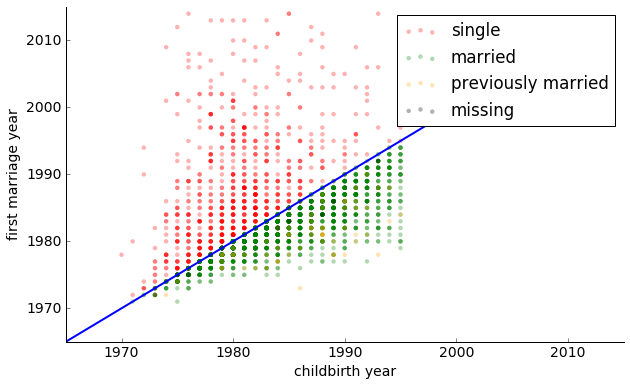

In [39]:
# plot prebirth month and marriage start year
married_df = merged[merged.yrbg1m_xrnd > 0]
plt.scatter(married_df[married_df.marstat==0].childbirth_year, married_df[married_df.marstat==0].yrbg1m_xrnd, 
            alpha=0.3, label='single', c='red')
plt.scatter(married_df[married_df.marstat==1].childbirth_year, married_df[married_df.marstat==1].yrbg1m_xrnd, 
            alpha=0.3, label='married', c='green')
plt.scatter(married_df[married_df.marstat==2].childbirth_year, married_df[married_df.marstat==2].yrbg1m_xrnd, 
            alpha=0.3, label='previously married', c='orange')
plt.scatter(married_df[married_df.marstat.isnull()].childbirth_year, married_df[married_df.marstat.isnull()].yrbg1m_xrnd, 
            alpha=0.3, label='missing', c='black')
plt.xlim([1965, 2015])
plt.ylim([1965, 2015])
plt.plot([1965, 2000], [1965, 2000])
plt.legend()
plt.xlabel('childbirth year')
plt.ylabel('first marriage year')
remove_border()

## Mothers' employment status

Variables Used:

* fam_7: WITH WHOM DID R LIVE AT AGE 14?
    * 11 FATHER-MOTHER
    * 12 FATHER-STEPMOTHER
    * 21 STEPFATHER-MOTHER
    * 22 STEPFATHER-STEPMOTHER
    * 31 MAN RELATIVE-MOTHER
    * 32 MAN RELATIVE-STEPMOTHER
    * 41 OTHER MAN-MOTHER
    * 42 OTHER MAN-STEPMOTHER
    * 51 NO MAN-MOTHER
    * 52 NO MAN-STEPMOTHER

* fam_8: RELATION TO R OF ADULT FEMALE IN HOUSEHOLD AT AGE 14
    * not usable, a lot of valid skips
       
* fam_9: DID ADULT FEMALE PRESENT IN HOUSEHOLD AT AGE 14 WORK FOR PAY?
    * 1 YES
    * 0 NO

In [40]:
mother_df = pd.read_csv('../data/mother.csv')
mother_df.head()

,caseid_1979,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979
0,1,11,-4,0,8,2,1
1,2,11,-4,0,5,3,-4
2,3,21,-4,1,10,1,2
3,4,21,-4,1,11,1,2
4,5,11,-4,1,12,1,1


In [41]:
merged = iv_df.merge(mother_df, on='caseid_1979')
merged.fam_7_1979.unique()

array([11, 21, 51, 15, 31, 33, 91, 44, 41, 54, 55, 12, 13, 53, 35, 80, -3,
       90, 45, 42, 19, 43, 22, 14])

In [42]:
def has_mom_fig(x):
    """
    Return whether R had mother/stepmothre figure, that is, 
    the variable fam_7 returns the following values: 
    * 11 FATHER-MOTHER
    * 12 FATHER-STEPMOTHER
    * 21 STEPFATHER-MOTHER
    * 22 STEPFATHER-STEPMOTHER
    * 31 MAN RELATIVE-MOTHER
    * 32 MAN RELATIVE-STEPMOTHER
    * 41 OTHER MAN-MOTHER
    * 42 OTHER MAN-STEPMOTHER
    * 51 NO MAN-MOTHER
    * 52 NO MAN-STEPMOTHER
    """
    
    return x in [11, 12, 21, 22, 31, 32, 41, 42, 51, 52]

merged['has_mom'] = merged.fam_7_1979.map(has_mom_fig)
merged.has_mom.value_counts()

True     3185
False     249
Name: has_mom, dtype: int64

In [43]:
merged.fam_9_1979.value_counts()

 1    1796
 0    1557
-4      57
-3      21
-2       3
Name: fam_9_1979, dtype: int64

In [44]:
def mom_worked(row):
    """
    Return whether mother figure (mother/stepmother) worked when R was at age 14. 
    """
    
    if row['has_mom']:
        if row['fam_9_1979'] == 1:
            return 1
        elif row['fam_9_1979'] == 0:
            return 0
    else:
        return 2 # no mother figure
    return None # catch missing

merged['mom_worked'] = merged.apply(mom_worked, axis=1)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979,has_mom,mom_worked
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,11,-4,0,5,3,-4,True,0.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,21,-4,1,10,1,2,True,1.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,21,-4,1,11,1,2,True,1.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,11,-4,1,9,1,1,True,1.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,11,-4,0,12,1,1,True,0.0


In [45]:
# merge 
iv_df = iv_df.merge(merged[['caseid_1979', 'mom_worked']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0


In [46]:
iv_df.mom_worked.value_counts(dropna=False)

 1.0    1710
 0.0    1461
 2.0     249
NaN       14
Name: mom_worked, dtype: int64

## Mothers' Education

In [47]:
# Respondents who reported no mother figure in the mother's employment question
# differ from those who reproted no mother figure in the mother's education question 

pd.crosstab(merged.has_mom, merged.hgc_mother_1979)

hgc_mother_1979,-4,-3,-2,-1,0,1,2,3,4,5,...,11,12,13,14,15,16,17,18,19,20
has_mom,,,,,,,,,,,,,,,,,,,,,
False,1,11,36,0,5,2,0,2,7,7,...,27,69,6,6,2,1,2,0,0,0
True,1,68,100,1,35,9,21,70,63,61,...,321,1126,85,132,22,133,22,16,2,3


In [48]:
def get_ma_educ(row):
    """
    Given respondent data row, return highest grade achieved by R's mother. 
    
    If R had no mother figure, code ma educ to category, not missing. 
    If R knew mother and invalid ma educ, set to missing.
    
    Value scheme:
    0 - no mother figure
    1 - less than high school
    2 - high school
    3 - some college
    4 - college
    5 - higher than college
    """
      
    if row['has_mom']:
        g = row['hgc_mother_1979'] # grade

        if g >= 0 and g<12:
            return 1

        elif g==12:
            return 2

        elif (g>12 and g<16):
            return 3

        elif g==16:
            return 4

        elif (g>16 and g<95):
            return 5
    
    else:
        return 0 # no mother figure

    return None # capture missing


merged['mom_educ'] = merged.apply(get_ma_educ, axis=1)
merged.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,fam_7_1979,fam_8_1979,fam_9_1979,hgc_mother_1979,fam_19_1979,fam_19c_1979,has_mom,mom_worked,mom_educ
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,11,-4,0,5,3,-4,True,0.0,1.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,21,-4,1,10,1,2,True,1.0,1.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,21,-4,1,11,1,2,True,1.0,1.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,11,-4,1,9,1,1,True,1.0,1.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,11,-4,0,12,1,1,True,0.0,2.0


In [49]:
# merge 
iv_df = iv_df.merge(merged[['caseid_1979', 'mom_educ']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0


In [50]:
iv_df.mom_educ.value_counts(dropna=False)

 1.0    1474
 2.0    1126
 0.0     249
 3.0     239
NaN      170
 4.0     133
 5.0      43
Name: mom_educ, dtype: int64

## Whether to work at age 35

Variables Used:
    
exp_1_1979: WHAT WOULD R LIKE TO BE DOING AT AGE 35?

* 1 PRESENT JOB
* 2 SOME OCCUPATION
* 3 MARRIED, FAMILY
* 4 OTHER (SPECIFY)

exp_2_1979: DOES R WANT TO WORK OUTSIDE HOME AT AGE 35?
* 1 YES
* 0 NO

In [51]:
# read attitude variables
att_df = pd.read_csv('../data/attitude.csv')
att_df.head()

,caseid_1979,fer_3_1979,womens_roles_000001_1979,womens_roles_000002_1979,womens_roles_000003_1979,womens_roles_000004_1979,womens_roles_000005_1979,womens_roles_000006_1979,womens_roles_000007_1979,womens_roles_000008_1979,...,exp_1_1981,exp_2_1981,womens_roles_000001_1982,womens_roles_000002_1982,womens_roles_000003_1982,womens_roles_000004_1982,womens_roles_000005_1982,womens_roles_000006_1982,womens_roles_000007_1982,womens_roles_000008_1982
0,1,2,2,2,1,1,4,2,1,4,...,1,-4,-5,-5,-5,-5,-5,-5,-5,-5
1,2,3,4,3,2,2,3,4,3,4,...,2,1,3,3,2,2,4,4,3,4
2,3,4,2,4,3,3,3,3,3,3,...,-5,-5,1,1,1,1,4,1,4,1
3,4,2,1,2,3,4,1,2,4,2,...,1,-4,1,1,4,2,4,2,4,2
4,5,3,2,2,2,1,3,3,3,2,...,1,-4,2,2,2,1,3,3,3,2


In [52]:
# crosstab
merged = iv_df.merge(att_df, on='caseid_1979')
pd.crosstab(merged.exp_1_1979, merged.exp_2_1979)

exp_2_1979,-4,-3,-2,0,1
exp_1_1979,,,,,
-3,2,0,0,0,0
-2,152,0,0,0,0
1,49,0,0,0,0
2,2323,0,0,0,0
3,0,23,1,291,459
4,134,0,0,0,0


In [53]:
def working35(i):
    """
    Given respondent id i, return whether respondent would like to work at age 35.
    
    Value scheme:
    0 - answered MARRIED, FAMILY & NO to the question DOES R WANT TO WORK OUTSIDE HOME AT AGE 35?
    2 - answered Don't Know. 
    1 - the rest, except missings
    """
    
    row = att_df[att_df.caseid_1979==i].iloc[0]
    
    if row['exp_1_1979']==-2: # answered Don't Know
        return 2
    
    elif row['exp_1_1979'] in [1, 2, 4]:
        return 1
    
    elif row['exp_1_1979']==3 and row['exp_2_1979']==1:
        return 1
    
    elif row['exp_1_1979']==3 and row['exp_2_1979']==0:
        return 0
    
    return None # capture missing


iv_df['work35'] = iv_df.caseid_1979.map(working35)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0


In [54]:
iv_df.work35.value_counts(dropna=False)

 1.0    2965
 0.0     291
 2.0     152
NaN       26
Name: work35, dtype: int64

## Women's role

In [55]:
#what are the possible answers for each role question?

for i in [1, 2, 4, 6, 8]:
    print 'question', i
    print att_df['womens_roles_00000%s_1979'%i].unique()

question 1
[ 2  4  1  3 -2 -3]
question 2
[ 2  3  4  1 -2 -3 -1]
question 4
[ 1  2  3  4 -2 -3]
question 6
[ 2  4  3  1 -3 -2]
question 8
[ 4  3  2  1 -2 -3 -1]


In [56]:
count_missing_only_one = []

def get_wm_roles(i):
    """
    Given a respondent id i, return the summary index of women's roles. 
    
    If one variable has missing value, expand its value.
    If more than one missing, return None.
    """
    
    row = att_df[att_df.caseid_1979==i].iloc[0]
    
    num_missing = sum([row['womens_roles_00000%s_1979'%i] < 0 for i in [1, 2, 4, 6, 8]])
    
    if num_missing == 0: # no missing
        return round(np.mean([int(row['womens_roles_00000%s_1979'%i]) for i in [1, 2, 4, 6, 8]]))
    
    elif num_missing == 1:
        count_missing_only_one.append(i)
        vals = [int(row['womens_roles_00000%s_1979'%i]) for i in [1, 2, 4, 6, 8] 
                if int(row['womens_roles_00000%s_1979'%i]) > 0]
        return round(np.mean(vals))
    
    else:
        return None
        

iv_df['womensroles'] = iv_df.caseid_1979.map(get_wm_roles)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0


In [57]:
iv_df.womensroles.value_counts(dropna=False)

 2.0    2200
 3.0     748
 1.0     399
 4.0      52
NaN       35
Name: womensroles, dtype: int64

In [58]:
len(count_missing_only_one)

101

## Ideal number of children

This variable was reported in 1979 and 1982. After comparing values from the two survey years, we decide to use the value reported in 1979. 

In [59]:
ideal_df = pd.read_csv('../data/ideal_num_child.csv')
ideal_df.head()

,caseid_1979,ideal_num_children_1979,ideal_num_children_1982
0,1,3,-5
1,2,3,3
2,3,3,2
3,4,3,2
4,5,3,2


In [60]:
# compare diff between the two years

merged = iv_df.merge(ideal_df, on='caseid_1979')

diff = defaultdict(list)

for i, row in merged.iterrows():
    if row['ideal_num_children_1979'] != row['ideal_num_children_1982']:
        pair = [str(int(row['ideal_num_children_1979'])), str(int(row['ideal_num_children_1982']))]
        pair.sort()
        diff[','.join(pair)].append(row['caseid_1979'])
        
for k, v in diff.items():
    print k, len(v)

0,7 1
0,6 1
0,4 3
0,3 6
0,2 13
0,1 5
1,6 4
-2,-5 1
1,4 24
1,5 5
1,2 115
1,3 27
-5,6 2
2,8 5
2,5 62
2,4 327
2,7 1
2,6 25
12,5 1
12,4 5
2,3 546
7,8 1
3,7 4
5,8 4
12,2 2
4,7 2
4,6 47
4,5 70
3,4 245
3,5 60
3,6 18
4,8 10
5,6 12
5,7 5
10,3 1
1,8 2
10,6 1
10,5 3
16,2 1
12,3 1
-2,10 1
-5,8 1
5,9 1
-5,2 37
-5,3 24
-5,0 1
-5,1 3
-1,2 1
-5,7 2
-5,4 12
-5,5 7
-3,4 3
-3,5 1
-3,2 4
-3,3 4
-2,5 1
-2,4 3
-5,12 1
15,2 1
3,9 1
-2,3 3
-2,2 5
10,4 3
4,9 1


In [61]:
# how many cases have differences in total?
v = list(itertools.chain.from_iterable(diff.values())) 
print len(v)

1789


In [62]:
# use variable reported in 1979
iv_df = iv_df.merge(ideal_df[['caseid_1979', 'ideal_num_children_1979']], on='caseid_1979')
iv_df.rename(columns={'ideal_num_children_1979': 'ideal'}, inplace=True) #rename columns

def recode_ideal(x):
    """
    Recode the variable ideal to integers or None. Topcode at 4. 
    """
    
    if x < 0:
        return None
    elif x > 4: # topcoded at 4
        return 4
    else:
        return int(x)
    
iv_df.ideal = iv_df.ideal.map(recode_ideal)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles,ideal
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0,3.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0,3.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0,3.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0,4.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0,2.0


In [63]:
sum(iv_df.ideal.isnull())

12

## Race

In [64]:
analytic_df = pd.read_csv('../data/analytic_df.csv') #includes race data
print analytic_df.columns[:5]

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd'],
      dtype='object')


In [65]:
iv_df = iv_df.merge(analytic_df[['caseid_1979', 'sample_race_1979']], on='caseid_1979')
iv_df = iv_df.rename(index=str, columns={"sample_race_1979": "race"})
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles,ideal,race
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0,3.0,3
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0,3.0,3
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0,3.0,3
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0,4.0,3
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0,2.0,3


## OTHER DESCRIPTIVE STATISTICS

## Total fertility

In [66]:
analytic_df.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd', u'c4dob_m_xrnd',
       u'c4dob_y_xrnd', u'c5dob_m_xrnd', u'c5dob_y_xrnd', u'c6dob_m_xrnd',
       u'c6dob_y_xrnd', u'c7dob_m_xrnd', u'c7dob_y_xrnd', u'c8dob_m_xrnd',
       u'c8dob_y_xrnd', u'c9dob_m_xrnd', u'c9dob_y_xrnd', u'c10dob_m_xrnd',
       u'c10dob_y_xrnd', u'c11dob_m_xrnd', u'c11dob_y_xrnd', u'y_dob',
       u'm_dob', u'y_age35', u'y_deceased', u'last_yr', u'attr_before35',
       u'deceased_before35', u'y_child18', u'deceased_child18',
       u'attr_child18'],
      dtype='object')

In [67]:
def get_num_child(i):
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]
    vals = [row['c%sdob_y_xrnd'%j] != -4 for j in range(1, 12)] # if not valid skip, then it's a birth
    return sum(vals)
  
iv_df['numchild'] = iv_df.caseid_1979.map(get_num_child)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles,ideal,race,numchild
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0,3.0,3,2
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0,3.0,3,3
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0,3.0,3,2
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0,4.0,3,3
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0,2.0,3,3


## Time between first and second birth

Assume that the child was born at the end of the month.

In [68]:
def get_time(i):
    """
    Return number of months between first childbirth and second childbirth. 
    Return None if no second child.
    """
    
    row = analytic_df[analytic_df.caseid_1979==i].iloc[0]

    if row['c2dob_y_xrnd']>0 and row['c2dob_m_xrnd']>0:
        return diff_month(datetime(row['c2dob_y_xrnd'], row['c2dob_m_xrnd'], 1), 
                          datetime(row['c1dob_y_xrnd'], row['c1dob_m_xrnd'], 1)) 
    else:
        return None  #only one child, NA
        

iv_df['time_btw_birth'] = iv_df.caseid_1979.map(get_time)
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles,ideal,race,numchild,time_btw_birth
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0,3.0,3,2,20.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0,3.0,3,3,28.0
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0,3.0,3,2,199.0
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0,4.0,3,3,38.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0,2.0,3,3,42.0


In [69]:
sum(iv_df.time_btw_birth.isnull()) # how many have only one child

579

## Yearly work hours since birth

In [70]:
merged = iv_df.merge(wkarray_df, on='caseid_1979')
merged = merged.merge(df79, on='caseid_1979')

In [71]:
# first, check missing job dates

for i, row in merged.iterrows():

    # month when employment seq starts - the month following first childbirth
    if int(row['childbirth_month']) == 12: 
        start_m = 1
        start_y = int(row['childbirth_year']) + 1
    else:
        start_m = int(row['childbirth_month']) + 1
        start_y = int(row['childbirth_year'])
        
    
    # month when employment seq ends - year + 18, then go back one month
    end_y = start_y + 18
    end_m = start_m
    if end_m == 1:
        end_y -= 1
        end_m = 12
    else:
        end_m -= 1    
    
    
    if start_y < 1978 and row['hrs_worked_wk_num0000_xrnd'] > 0: # need to count for pre-1978 months
        
        # find start and stop dates for all jobs
        job_dates = find_job_dates(row)
    
        for job in job_dates:
            i, job_start_y, job_start_m, job_start_d, job_stop_y, job_stop_m, job_stop_d = job
            
            if job_start_y < 0 or job_start_m < 0 or job_stop_y < 0 or job_stop_m < 0:
                print row['caseid_1979'], (start_y, start_m), job_dates
                
                
        #### found missing job start time ####
        # id 5425, start_m (1976, 1), [(3, 1974.0, -2.0, -2.0, 1978.0, 2.0, 1.0)]
        # id 10521, start_m (1976, 9), [(2, 1976.0, 5.0, 15, 1978.0, 11.0, 15), (3, 1975.0, -2.0, -2.0, 1978.0, 7.0, 15)]


5425.0 (1976, 1) [(3, 1974.0, -2.0, -2.0, 1978.0, 2.0, 1.0)]
10521.0 (1976, 9) [(2, 1976.0, 5.0, 15, 1978.0, 11.0, 15), (3, 1975.0, -2.0, -2.0, 1978.0, 7.0, 15)]


In [72]:
count_expanded = []

def get_cum_exp(row):
    """
    Return yearly cumulative work experience.
    
    If missing < 10%, expand.
    Otherwise, assign missing.
    """
    
    # month when employment seq starts - the month following first childbirth
    if int(row['childbirth_month']) == 12: 
        start_m = 1
        start_y = int(row['childbirth_year']) + 1
    else:
        start_m = int(row['childbirth_month']) + 1
        start_y = int(row['childbirth_year'])
        
    
    # month when employment seq ends - year + 18, then go back one month
    end_y = start_y + 18
    end_m = start_m
    if end_m == 1:
        end_y -= 1
        end_m = 12
    else:
        end_m -= 1    
    
    
    total_wks = count_weeks(datetime(start_y, start_m, 1), datetime(end_y, end_m, 1))
    total_hours = 0
    missing_wks = 0
    
    if start_y < 1978 and row['hrs_worked_wk_num0000_xrnd'] > 0: # need to count for pre-1978 months
        
        # find start and stop dates for all jobs
        job_dates = find_job_dates(row)

        # select only jobs that started before 1978 and lasted after seq start month
        selected_jobs = [job for job in job_dates if job[1] < 1978 and \
                         datetime(int(job[4]), int(job[5]), int(job[6])) >= datetime(start_y, start_m, 1)]
    
        if len(selected_jobs) > 0: # skip if no qualified job

            for job in selected_jobs:
                i, job_start_y, job_start_m, job_start_d, job_stop_y, job_stop_m, job_stop_d = job
                
                # - handle missing start month -
                # if job started in year before seq start year and month is missing
                # we know R was working since seq start month
                # so assign job start date to seq start month
                if job_start_y < start_y and job_start_m < 0:
                    print 'id:', row['caseid_1979'], 'job #:', i
                    job_start_y, job_start_m, job_start_d = start_y, start_m, 1
                

                # only look at work months that are between seq start month and 1977/12
                job_start_date = max([datetime(start_y, start_m, 1), datetime(int(job_start_y), int(job_start_m), int(job_start_d))])                
                job_stop_date = min([datetime(1977, 12, 31), datetime(int(job_stop_y), int(job_stop_m), int(job_stop_d))])

                num_wks_worked = count_weeks(job_start_date, job_stop_date)
                hours_per_week = row['hours_per_week_job_%02d_1979'%i]

                if hours_per_week < 0:
                    if len(selected_jobs) == 1:
                        missing_wks += num_wks_worked
                    else:
                        raise Exception, 'unexpected missing job pre-1978'
                        #print int(row['caseid_1979']), (start_y, start_m), selected_jobs
                        #missing_wks = ???

                else:
                    total_hours += hours_per_week*num_wks_worked
                

    #### now handle post-1978 part ####

    start_wk = 1
    if start_y >= 1978: # seq start month is after 1978
        start_wk = get_week_num(start_y, start_m, 'first')
    
    # assume child birth happened in the last week of the month
    stop_wk = get_week_num(end_y, end_m, 'last')

    # get hours worked per week between week 1 and stop_wk
    hours = [row['hrs_worked_wk_num%04d_xrnd'%w] for w in range(start_wk, stop_wk+1) 
             if row['hrs_worked_wk_num%04d_xrnd'%w] >= 0]

    # update 
    missing_wks += stop_wk + 1 - start_wk - len(hours)
    total_hours += sum(hours)

    # handle missingness
    pct_valid = 1 - float(missing_wks)/total_wks

    if pct_valid == 1: # if no missing weeks, return sum of hours
        return int(total_hours)

    elif pct_valid > 0.9: # if missing <= 10%, scale up to 1 
        #print 'scaled up - respondent', int(row['caseid_1979'])
        count_expanded.append(row['caseid_1979'])
        return int(round(total_hours/pct_valid))

    return None
      
    
merged['yr_cum_exp'] = merged.apply(get_cum_exp, axis=1)
merged.head()

id: 5425.0 job #: 3
id: 10521.0 job #: 3


,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979,yr_cum_exp
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,-4,-4,-4,-4,0,-4,-4,-4,-4,7901.0
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,-4,-4,-4,-4,0,0,0,-4,-4,12178.0
2,4,1980,8,1962,8,17,1,0.0,0,0,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,21815.0
3,8,1976,3,1958,7,17,1,0.0,0,0,...,-4,-4,-4,-4,1,-4,-4,-4,-4,26499.0
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,-4,-4,-4,-4,1,-4,-4,-4,-4,26517.0


In [73]:
iv_df = iv_df.merge(merged[['caseid_1979', 'yr_cum_exp']], on='caseid_1979')
iv_df['yr_cum_exp'] = iv_df.yr_cum_exp/2000
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,marstat,mom_worked,mom_educ,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp
0,2,1993,3,1959,1,34,2,27700.0,1,1,1.0,0.0,1.0,1.0,3.0,3.0,3,2,20.0,3.9505
1,3,1981,6,1961,8,19,1,5603.0,1,1,1.0,1.0,1.0,0.0,3.0,3.0,3,3,28.0,6.0890
2,4,1980,8,1962,8,17,1,0.0,0,0,0.0,1.0,1.0,0.0,2.0,3.0,3,2,199.0,10.9075
3,8,1976,3,1958,7,17,1,0.0,0,0,1.0,1.0,1.0,1.0,2.0,4.0,3,3,38.0,13.2495
4,16,1990,2,1958,10,31,3,27263.0,1,1,1.0,0.0,2.0,1.0,2.0,2.0,3,3,42.0,13.2585


In [74]:
# how many cases missing < 10% and expanded?
len(count_expanded)

278

In [75]:
# how many cases missing?
sum(iv_df.yr_cum_exp.isnull())

54

## number of FT months

In [76]:
monthly_df = pd.read_csv('../data/monthly_df_for_testing2.csv')
monthly_df.head()

,caseid_1979,month1,month2,month3,month4,month5,month6,month7,month8,month9,...,month219,month220,month221,month222,month223,month224,month225,month226,month227,month228
0,2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,4,4,4,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,0,0,0
3,8,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
4,16,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [77]:
def count_ft_months(row):
    counts = [row['month%s'%i]==1 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_ft_months'] = monthly_df.apply(count_ft_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_ft_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,mom_worked,mom_educ,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,0.0,1.0,1.0,3.0,3.0,3,2,20.0,3.9505,11
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,1.0,1.0,0.0,3.0,3.0,3,3,28.0,6.0890,48
2,4,1980,8,1962,8,17,1,0.0,0,0,...,1.0,1.0,0.0,2.0,3.0,3,2,199.0,10.9075,107
3,8,1976,3,1958,7,17,1,0.0,0,0,...,1.0,1.0,1.0,2.0,4.0,3,3,38.0,13.2495,127
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,0.0,2.0,1.0,2.0,2.0,3,3,42.0,13.2585,89


## number of PT months

In [78]:
def count_pt_months(row):
    counts = [row['month%s'%i]==3 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_pt_months'] = monthly_df.apply(count_pt_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_pt_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,mom_educ,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,1.0,1.0,3.0,3.0,3,2,20.0,3.9505,11,78
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,1.0,0.0,3.0,3.0,3,3,28.0,6.0890,48,9
2,4,1980,8,1962,8,17,1,0.0,0,0,...,1.0,0.0,2.0,3.0,3,2,199.0,10.9075,107,16
3,8,1976,3,1958,7,17,1,0.0,0,0,...,1.0,1.0,2.0,4.0,3,3,38.0,13.2495,127,11
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,2.0,1.0,2.0,2.0,3,3,42.0,13.2585,89,117


## number of nonemployed months

In [79]:
def count_nonemp_months(row):
    counts = [row['month%s'%i]==4 for i in range(1, 217)]
    return sum(counts)


monthly_df['num_nonemp_months'] = monthly_df.apply(count_nonemp_months, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_nonemp_months']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,work35,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,1.0,3.0,3.0,3,2,20.0,3.9505,11,78,125
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,0.0,3.0,3.0,3,3,28.0,6.0890,48,9,159
2,4,1980,8,1962,8,17,1,0.0,0,0,...,0.0,2.0,3.0,3,2,199.0,10.9075,107,16,90
3,8,1976,3,1958,7,17,1,0.0,0,0,...,1.0,2.0,4.0,3,3,38.0,13.2495,127,11,63
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,1.0,2.0,2.0,3,3,42.0,13.2585,89,117,0


## number of unemployed spells longer than 3 months

In [80]:
# for example, look at one respondent in the second row
row = monthly_df.iloc[1]

counts = [str(int(row['month%s'%i]==4)) for i in range(1, 217)] # convert unemployed months to 1, other months to 0
s = ''.join(counts) # combine into a string
unemployed_spells = s.split('0') # cut by 0
print unemployed_spells
unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
print len(unemployed_spells_counts)

['', '', '', '', '', '', '', '', '', '', '11111111111111111111111111111111111', '', '', '', '', '', '111111111111111111111', '', '', '', '', '', '', '1111111111', '', '', '', '1111111111', '', '', '', '', '', '', '', '', '111111111111111111', '111', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '1111111111111111111111111111111111111111111111111111111', '', '111', '1111', '']
9


In [81]:
def count_spells(row):
    
    # convert unemployed months to 1, others to 0. then combine into a string
    counts = [str(int(row['month%s'%i]==4)) for i in range(1, 217)]
    s = ''.join(counts)
    
    unemployed_spells = s.split('0')
    unemployed_spells_counts = [spell for spell in unemployed_spells if len(spell) >= 3] # only include unemployed spells >= 3 months
    return len(unemployed_spells_counts)


monthly_df['num_nonemp_spells'] = monthly_df.apply(count_spells, axis=1)
iv_df = iv_df.merge(monthly_df[['caseid_1979', 'num_nonemp_spells']], on='caseid_1979')
iv_df.head()

,caseid_1979,childbirth_year,childbirth_month,y_dob,m_dob,age,educ,exp,working,had_job,...,womensroles,ideal,race,numchild,time_btw_birth,yr_cum_exp,num_ft_months,num_pt_months,num_nonemp_months,num_nonemp_spells
0,2,1993,3,1959,1,34,2,27700.0,1,1,...,3.0,3.0,3,2,20.0,3.9505,11,78,125,1
1,3,1981,6,1961,8,19,1,5603.0,1,1,...,3.0,3.0,3,3,28.0,6.0890,48,9,159,9
2,4,1980,8,1962,8,17,1,0.0,0,0,...,2.0,3.0,3,2,199.0,10.9075,107,16,90,5
3,8,1976,3,1958,7,17,1,0.0,0,0,...,2.0,4.0,3,3,38.0,13.2495,127,11,63,3
4,16,1990,2,1958,10,31,3,27263.0,1,1,...,2.0,2.0,3,3,42.0,13.2585,89,117,0,0


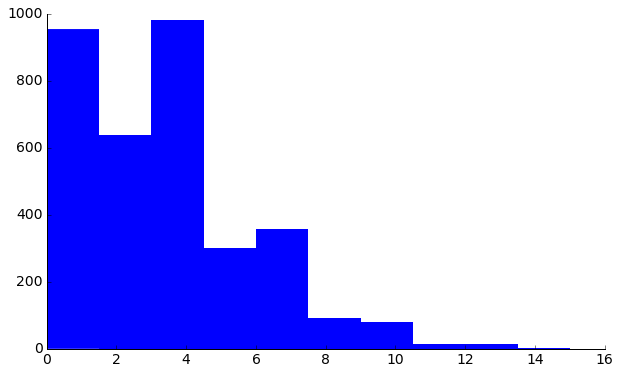

In [82]:
plt.hist(iv_df.num_nonemp_spells)
remove_border()

In [83]:
# export to csv
iv_df.to_csv('../data/iv_df_for_testing.csv', index=False)